In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 19:43:06.534210: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 19:43:07.334619: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 19:43:07.379210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 19:43:07.379268: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 19:43:07.383823: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 19:43:07.383890: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 19:43:07.385861: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

iawe_gen_GASF_13m_100S5X4A1545_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['air conditioner', 'computer', 'fridge', 'television']
{0: 2.2888888888888888, 1: 0.8442622950819673, 2: 0.46119402985074626, 3: 4.753846153846154}
 
Tests 
air conditioner test: 34 train: 135
computer test: 92 train: 366
fridge test: 167 train: 670
television test: 16 train: 65


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/iawe/TL/iawe_82_refit, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data iawe training on model refit seed 82
reading data, printing stats: 
['air conditioner', 'computer', 'fridge', 'television']
{0: 2.2888888888888888, 1: 0.8442622950819673, 2: 0.46119402985074626, 3: 4.753846153846154}
 
Tests 
air conditioner test: 34 train: 135
computer test: 92 train: 366
fridge test: 167 train: 670
television test: 16 train: 65
loading model
compling TL model..


2022-02-11 19:43:07.954464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 19:43:07.954793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 19:43:07.954853: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 19:43:08.317497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 19:43:08.317533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 19:43:08.317543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 19:43:08.318118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 19:43:16.023759: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 19:43:16.044511: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 19:43:19.492535: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 19:43:19.973423: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 19:43:20.456286: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 19:43:20.864949: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


39/39 - 6s - loss: 0.6447 - accuracy: 0.6780
Epoch 2/50
39/39 - 1s - loss: 0.1921 - accuracy: 0.9239
Epoch 3/50
39/39 - 1s - loss: 0.1777 - accuracy: 0.9256
Epoch 4/50
39/39 - 1s - loss: 0.1527 - accuracy: 0.9312
Epoch 5/50
39/39 - 1s - loss: 0.1484 - accuracy: 0.9393
Epoch 6/50
39/39 - 1s - loss: 0.1235 - accuracy: 0.9515
Epoch 7/50
39/39 - 1s - loss: 0.1119 - accuracy: 0.9498
Epoch 8/50
39/39 - 1s - loss: 0.1236 - accuracy: 0.9401
Epoch 9/50
39/39 - 1s - loss: 0.1256 - accuracy: 0.9377
Epoch 10/50
39/39 - 1s - loss: 0.1075 - accuracy: 0.9474
Epoch 11/50
39/39 - 1s - loss: 0.1187 - accuracy: 0.9466
Epoch 12/50
39/39 - 1s - loss: 0.1067 - accuracy: 0.9450
Epoch 13/50
39/39 - 1s - loss: 0.0925 - accuracy: 0.9555
Epoch 14/50
39/39 - 1s - loss: 0.1038 - accuracy: 0.9515
Epoch 15/50
39/39 - 1s - loss: 0.0846 - accuracy: 0.9563
Epoch 16/50
39/39 - 1s - loss: 0.1131 - accuracy: 0.9490
Epoch 17/50
39/39 - 1s - loss: 0.0989 - accuracy: 0.9490
Epoch 18/50
39/39 - 1s - loss: 0.1242 - accuracy: 0

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
39/39 - 4s - loss: 0.8301 - accuracy: 0.6214
Epoch 2/50
39/39 - 1s - loss: 0.2767 - accuracy: 0.8851
Epoch 3/50
39/39 - 1s - loss: 0.2157 - accuracy: 0.9142
Epoch 4/50
39/39 - 1s - loss: 0.1866 - accuracy: 0.9337
Epoch 5/50
39/39 - 1s - loss: 0.1815 - accuracy: 0.9248
Epoch 6/50
39/39 - 1s - loss: 0.1511 - accuracy: 0.9377
Epoch 7/50
39/39 - 1s - loss: 0.1439 - accuracy: 0.9401
Epoch 8/50
39/39 - 1s - loss: 0.1459 - accuracy: 0.9328
Epoch 9/50
39/39 - 1s - loss: 0.1462 - accuracy: 0.9296
Epoch 10/50
39/39 - 1s - loss: 0.1490 - accuracy: 0.9401
Epoch 11/50
39/39 - 1s - loss: 0.1375 - accuracy: 0.9409
Epoch 12/50
39/39 - 1s - loss: 0.1264 - accuracy: 0.9426
Epoch 13/50
39/39 - 1s - loss: 0.1043 - accuracy: 0.9506
Epoch 14/50
39/39 - 1s - loss: 0.1206 - accuracy: 0.9466
Epoch 15/50
39/39 - 1s - loss: 0.1010 - accuracy: 0.9515
Epoch 16/50
39/39 - 1s - loss: 0.0965 - accuracy: 0.9604
Epoch 17/50
39/39 - 1s - loss: 0.1131 - accuracy: 0.9531
Epoch 1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
39/39 - 4s - loss: 0.7966 - accuracy: 0.7362
Epoch 2/50
39/39 - 1s - loss: 0.3345 - accuracy: 0.8811
Epoch 3/50
39/39 - 1s - loss: 0.3075 - accuracy: 0.8794
Epoch 4/50
39/39 - 1s - loss: 0.2617 - accuracy: 0.8997
Epoch 5/50
39/39 - 1s - loss: 0.2348 - accuracy: 0.9005
Epoch 6/50
39/39 - 1s - loss: 0.2329 - accuracy: 0.8948
Epoch 7/50
39/39 - 1s - loss: 0.2248 - accuracy: 0.8997
Epoch 8/50
39/39 - 1s - loss: 0.2317 - accuracy: 0.8989
Epoch 9/50
39/39 - 1s - loss: 0.1994 - accuracy: 0.9086
Epoch 10/50
39/39 - 1s - loss: 0.2038 - accuracy: 0.9126
Epoch 11/50
39/39 - 1s - loss: 0.2119 - accuracy: 0.9094
Epoch 12/50
39/39 - 1s - loss: 0.2025 - accuracy: 0.9029
Epoch 13/50
39/39 - 1s - loss: 0.1940 - accuracy: 0.9183
Epoch 14/50
39/39 - 1s - loss: 0.1758 - accuracy: 0.9199
Epoch 15/50
39/39 - 1s - loss: 0.1937 - accuracy: 0.9191
Epoch 16/50
39/39 - 1s - loss: 0.1999 - accuracy: 0.9070
Epoch 17/50
39/39 - 1s - loss: 0.1853 - accuracy: 0.9183
Epoch 1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
39/39 - 4s - loss: 0.8193 - accuracy: 0.5890
Epoch 2/50
39/39 - 1s - loss: 0.3167 - accuracy: 0.8649
Epoch 3/50
39/39 - 1s - loss: 0.2351 - accuracy: 0.8948
Epoch 4/50
39/39 - 1s - loss: 0.2208 - accuracy: 0.9078
Epoch 5/50
39/39 - 1s - loss: 0.1917 - accuracy: 0.9248
Epoch 6/50
39/39 - 1s - loss: 0.1619 - accuracy: 0.9248
Epoch 7/50
39/39 - 1s - loss: 0.1664 - accuracy: 0.9264
Epoch 8/50
39/39 - 1s - loss: 0.1398 - accuracy: 0.9369
Epoch 9/50
39/39 - 1s - loss: 0.1517 - accuracy: 0.9345
Epoch 10/50
39/39 - 1s - loss: 0.1320 - accuracy: 0.9458
Epoch 11/50
39/39 - 1s - loss: 0.1281 - accuracy: 0.9369
Epoch 12/50
39/39 - 1s - loss: 0.0966 - accuracy: 0.9555
Epoch 13/50
39/39 - 1s - loss: 0.1440 - accuracy: 0.9345
Epoch 14/50
39/39 - 1s - loss: 0.1312 - accuracy: 0.9466
Epoch 15/50
39/39 - 1s - loss: 0.1139 - accuracy: 0.9434
Epoch 16/50
39/39 - 1s - loss: 0.1256 - accuracy: 0.9385
Epoch 17/50
39/39 - 1s - loss: 0.1102 - accuracy: 0.9450
Epoch 1

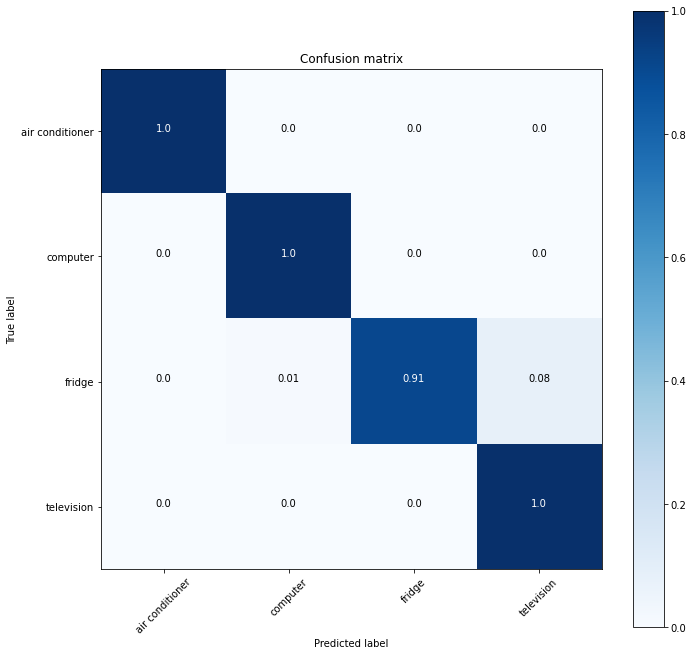

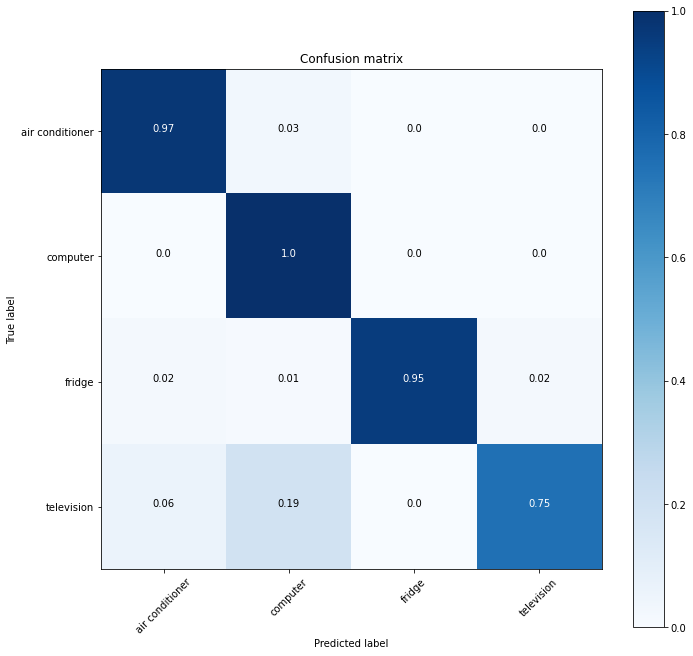

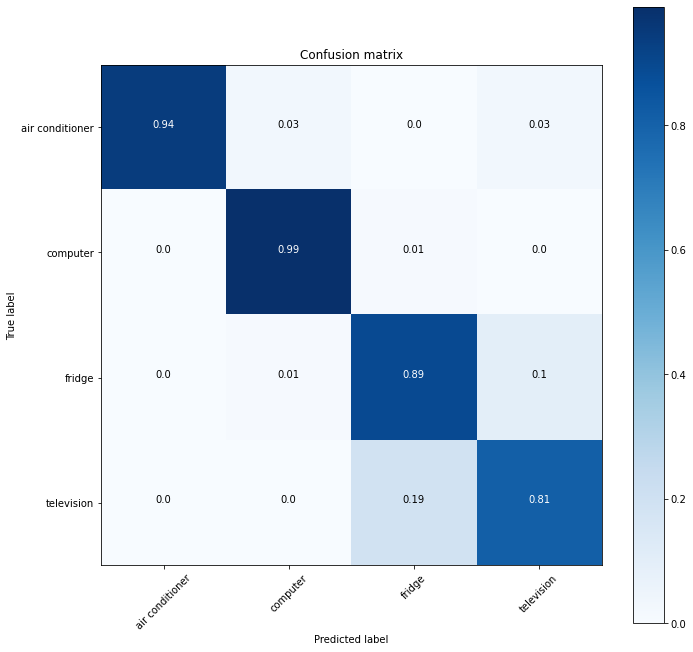

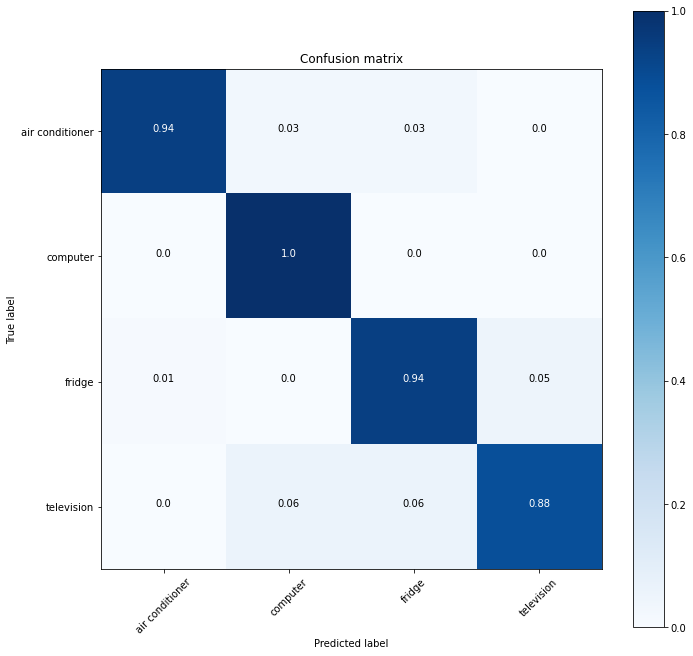

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()